In [1]:
from skimage import io
import scipy.interpolate
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from scipy.signal import find_peaks
dtype = torch.float32

## Load PSF Data

In [2]:
im = io.imread('calibrationData_8bit.tif')
A = im[:,int(im.shape[1]/2),:]
A = torch.tensor(A, dtype = dtype).T

## Load Measurement Data

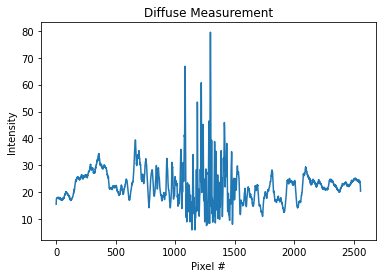

In [15]:
meas = io.imread('depthPos_#0004_8bit.tif')
meas = torch.tensor(meas[:,int(meas.shape[1]/2),:],dtype = dtype)
meas = torch.mean(meas,0)

plt.figure()
plt.plot(meas)
plt.xlabel('Pixel #')
plt.ylabel('Intensity')
plt.title('Diffuse Measurement')
plt.show()

## Set Up Variables and Helper Functions

In [61]:
start_wave = 790
end_wave = 860
num_waves = 161
waves = torch.linspace(start_wave,end_wave,num_waves)
depth = torch.linspace(0,1/(end_wave-start_wave)*(num_waves-1),num_waves)
window = torch.tensor(np.hanning(len(waves)))
# recon_window = torch.ones_like(window)
recon_window = window + .1

def moving_average(a, n=10) :
    # This only works for even n currently. Should be easy fix but too lazy rn
    filtered = torch.zeros_like(a)
    ret = torch.cumsum(a, 0)
    ret[n:] = ret[n:] - ret[:-n]
    filtered[int(n/2)-1:-int(n/2)] = ret[n - 1:] / n
    filtered[0:int(n/2)-1] = filtered[int(n/2)-1]
    filtered[-int(n/2):] = filtered[-int(n/2)-1]
    return filtered

def dc_estimate(waves, signal, width):
    peaks, _ = find_peaks(signal, height=-10)
    valleys, _ = find_peaks(-signal, height=-10)
    length = np.min((len(peaks),len(valleys)))
    x = np.zeros(length+2)
    mid = np.zeros(length+2)
    for ii in range(length):
        if np.min(valleys)<np.min(peaks):
            x[ii+1] = (waves[valleys[ii]] - waves[peaks[ii]])/2 + waves[peaks[ii]]
            mid[ii+1] = (signal[peaks[ii]]-signal[valleys[ii]])/2 + signal[valleys[ii]]
        else:
            x[ii+1] = (-waves[valleys[ii]] + waves[peaks[ii]])/2 + waves[valleys[ii]]
            mid[ii+1] = (signal[peaks[ii]]-signal[valleys[ii]])/2 + signal[valleys[ii]]
    x[0] = waves[0]
    mid[0] = signal[0]
    x[-1] = waves[-1]
    mid[-1] = signal[-1]
    plt.figure(figsize = (15,10))
    plt.plot(waves[peaks],signal[peaks],'x')
    plt.plot(waves[valleys],signal[valleys],'x')
    plt.plot(waves,signal)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('DC Estimation')
    plt.plot(x,mid)
    smoothed = moving_average(torch.tensor(mid), width)
    interp = scipy.interpolate.interp1d(x, smoothed,'cubic')
    interp_dc = torch.tensor(interp(waves),dtype = dtype)
    return interp_dc

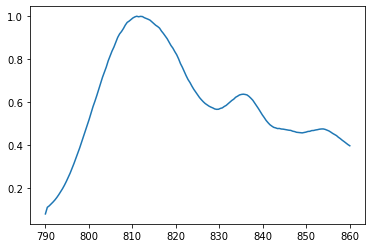

In [62]:
# A better DC estimate maybe
plt.figure()
plt.plot(waves,torch.mean(A,0)/torch.max(torch.mean(A,0)))
plt.show()

## Load and Process Ground Truth

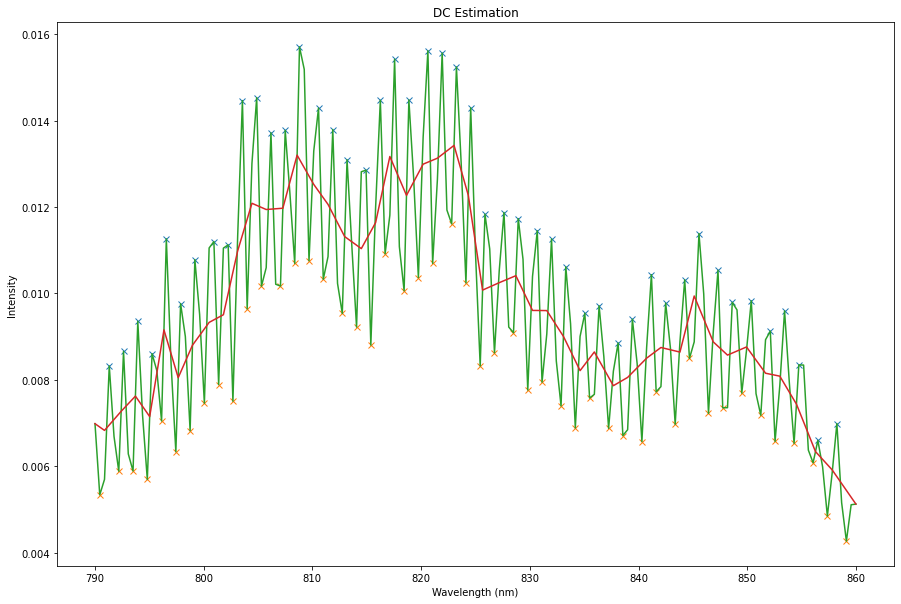

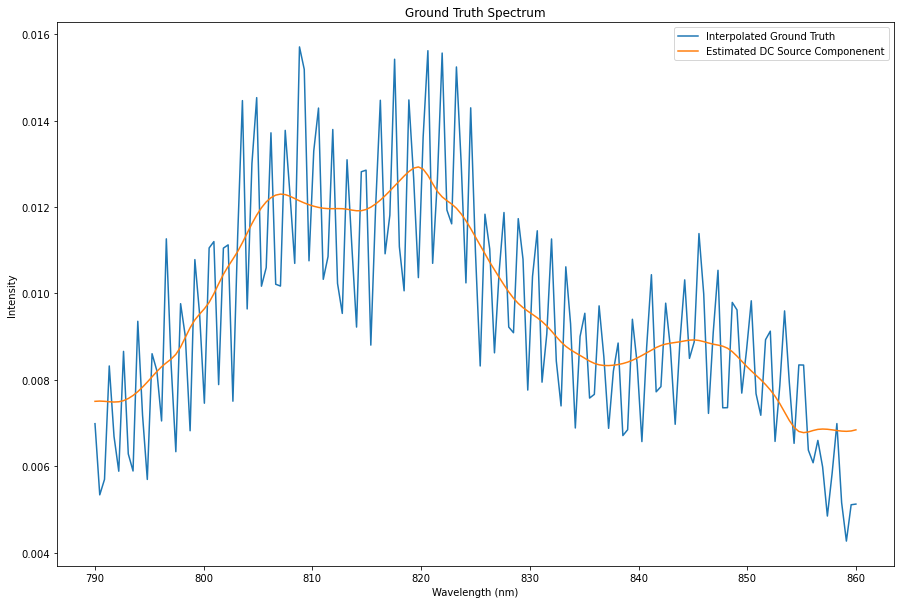

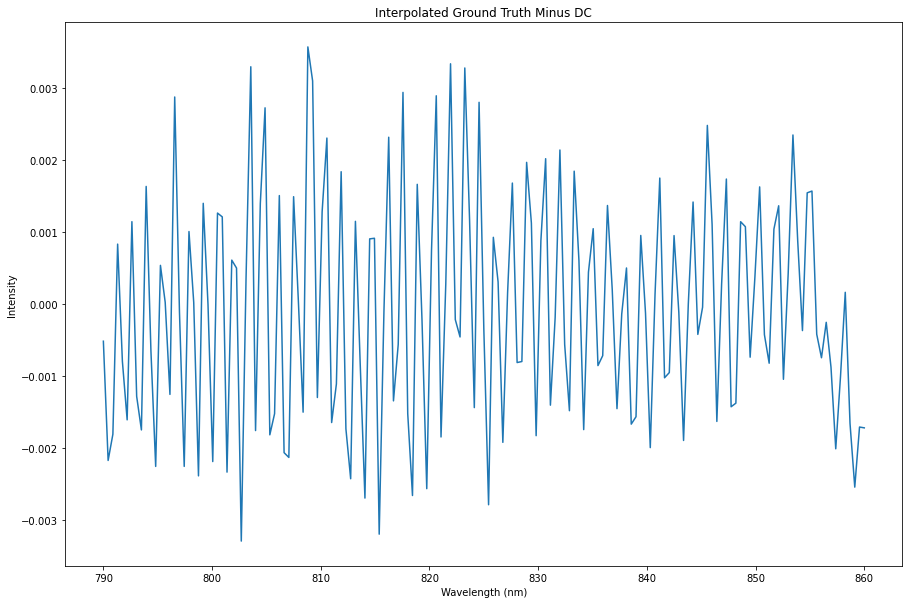

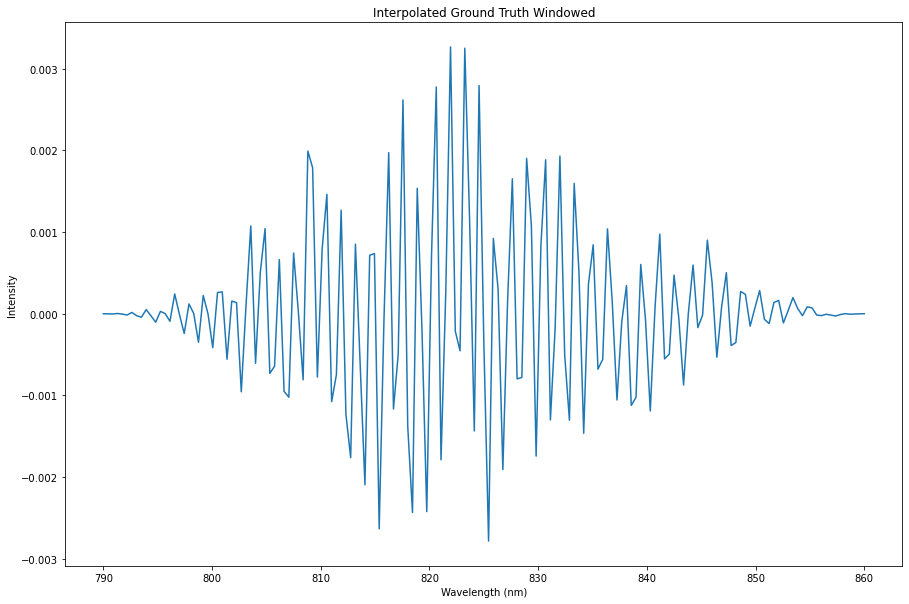

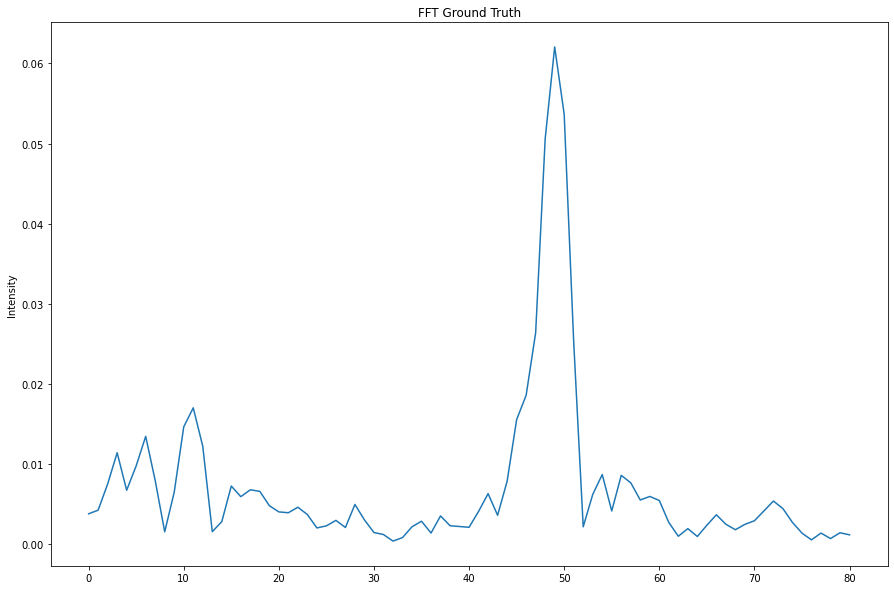

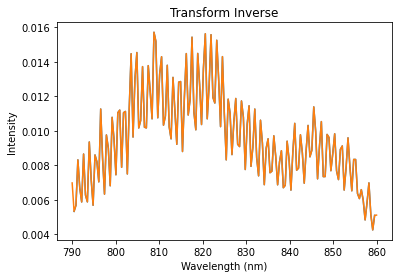

In [71]:
%matplotlib inline
gt = scipy.io.loadmat('GroundTruth/400umGT.mat')['ans']
start = np.argmin(abs(gt[:,0]-(start_wave-1)))
end = np.argmin(abs(gt[:,0]-(end_wave+1)))
gt_waves = torch.tensor(gt[start:end,0])
gt_intensity = torch.tensor(gt[start:end,1])

# Resample GT to Calibration Wavelengths
interp = scipy.interpolate.interp1d(gt_waves,gt_intensity,'cubic')
interp_gt = torch.tensor(interp(waves),dtype = dtype)
scaling_factor = torch.max(torch.matmul(A,interp_gt))/torch.max(meas)
interp_gt = interp_gt/scaling_factor

# Calculate and display DC signal
interp_dc = dc_estimate(waves, interp_gt, 6)

# Display Interpolated Ground Truth
plt.figure(figsize =(15,10))
plt.plot(waves, interp_gt)
plt.plot(waves, interp_dc)
plt.legend(['Interpolated Ground Truth', 'Estimated DC Source Componenent'])
plt.title('Ground Truth Spectrum')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display DC Corrected Spectrum
interp_gt_corrected = interp_gt-interp_dc
plt.figure(figsize =(15,10))
plt.plot(waves, interp_gt_corrected)
plt.title('Interpolated Ground Truth Minus DC')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display windowed spectrum
interp_gt_windowed = interp_gt_corrected * window
plt.figure(figsize = (15,10))
plt.plot(waves, interp_gt_windowed)
plt.title('Interpolated Ground Truth Windowed')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display FFT
interp_gt_fft = torch.fft.fftn(interp_gt_windowed)
recon = torch.fft.fftshift(interp_gt_fft).abs()[int(len(interp_gt)/2):]
plt.figure(figsize = (15,10))
plt.plot(recon)
plt.title('FFT Ground Truth')
plt.ylabel('Intensity')
plt.show()

# Display Inversion
inv = torch.fft.ifftn(interp_gt_fft).real/window + interp_dc
plt.figure()
plt.plot(waves, inv)
plt.plot(waves, interp_gt)
plt.title('Transform Inverse')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Need a better DC estimate
# Maybe try a different domain for sparsity

## Adjoint Check

In [36]:
x = torch.randn_like(waves)
y = torch.randn_like(meas)
print(torch.dot(torch.matmul(A,x),y))
print(torch.dot(x,torch.matmul(A.T,y)))

tensor(4861.9521)
tensor(4861.9463)


## Define Functions for Proximal Operator

In [37]:
def sparse_transform(signal, dc):
    return torch.fft.fftn((signal-dc)*recon_window)

def inv_sparse_transform(signal, dc):
    return (torch.fft.ifftn(signal).real/recon_window+dc).type(dtype)

def complex_soft_thr(signal, gamma):
    imag = signal.imag
    real = signal.real
    return torch.sign(real)*torch.clamp(torch.abs(real)-gamma,min=0) + imag*1j

In [70]:
oct_solve = torch.fft.fftshift(interp_gt_fft).abs()[int(len(interp_gt)/2):]

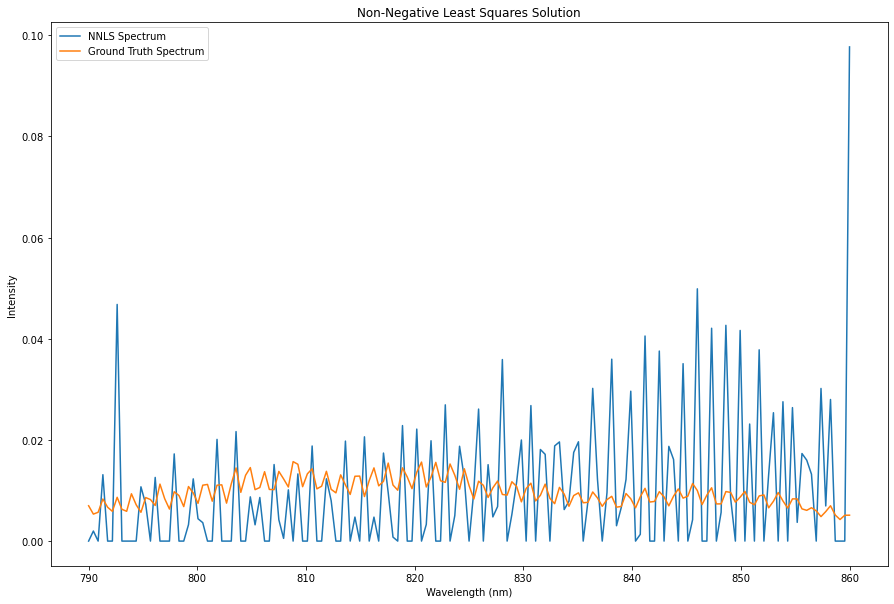

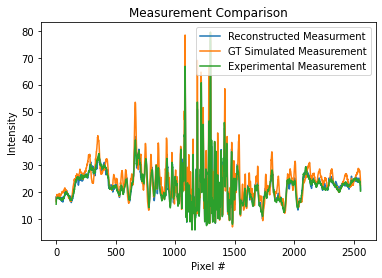

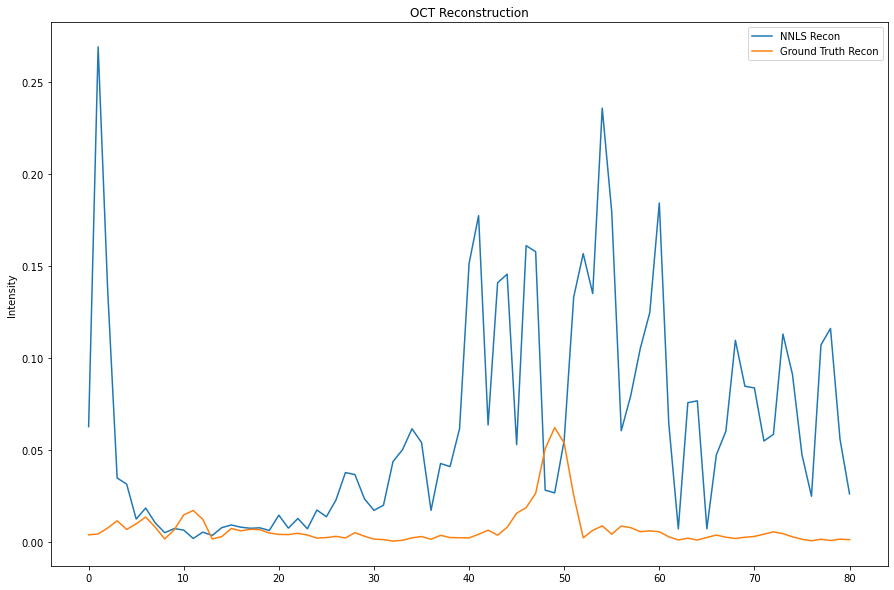

In [75]:
from scipy.optimize import nnls
test = nnls(A,meas)[0]
plt.figure(figsize = (15,10))
plt.plot(waves, test)
plt.plot(waves, interp_gt)
plt.title('Non-Negative Least Squares Solution')

plt.legend(['NNLS Spectrum','Ground Truth Spectrum'])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

plt.figure()
plt.plot(torch.matmul(A,torch.tensor(test,dtype = dtype)))
plt.plot(torch.matmul(A,interp_gt))
plt.plot(meas)
plt.title('Measurement Comparison')
plt.legend(['Reconstructed Measurment', 'GT Simulated Measurement', 'Experimental Measurement'])
plt.xlabel('Pixel #')
plt.ylabel('Intensity')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(oct_solve)
plt.plot(recon)
plt.legend(['NNLS Recon','Ground Truth Recon'])
plt.title('OCT Reconstruction')
plt.ylabel('Intensity')
plt.show()


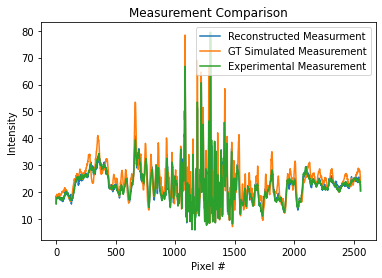

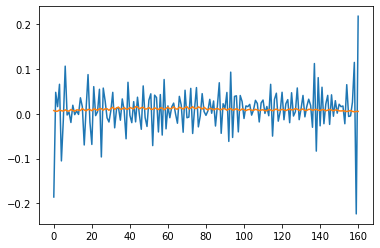

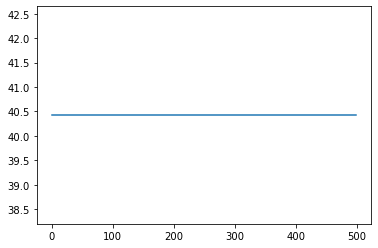

In [83]:
recon = torch.zeros_like(waves, dtype = dtype)
step_size = 3e-9
iters = 500
lam = 1e-15
gams = torch.logspace(.0001,1,100)
pinv = torch.pinverse(A,lam)



loss = []
recon = torch.matmul(pinv,meas)
recon = torch.zeros_like(recon)
recon = interp_gt
for ii in range(iters):
#     residual = torch.matmul(A,recon)-meas
#     calc_g = 2*torch.matmul(A.T,residual)
#     plt.figure()
#     plt.plot(calc_g*step_size)
#     plt.plot(recon)
#     plt.show()
#     z = recon - step_size*calc_g
    b = torch.matmul(pinv,meas) + lam * recon
    recon = torch.matmul(pinv,torch.matmul(A,b))
#     dc = interp_dc
#     recon = inv_sparse_transform(complex_soft_thr(sparse_transform(z,dc),.01),interp_dc)
    loss.append(torch.norm(torch.matmul(A,recon)-meas))

plt.figure()
plt.plot(torch.matmul(A,recon))
plt.plot(torch.matmul(A,interp_gt))
plt.plot(meas)
plt.title('Measurement Comparison')
plt.legend(['Reconstructed Measurment', 'GT Simulated Measurement', 'Experimental Measurement'])
plt.xlabel('Pixel #')
plt.ylabel('Intensity')
plt.show()

plt.figure()
plt.plot(recon)
plt.plot(interp_gt)
plt.show()

plt.figure()
plt.plot(loss)
plt.show()


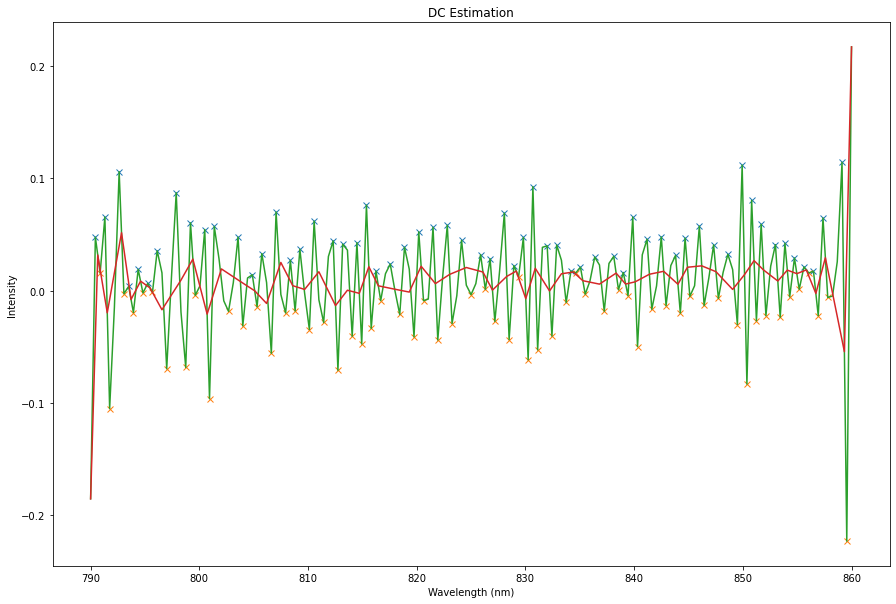

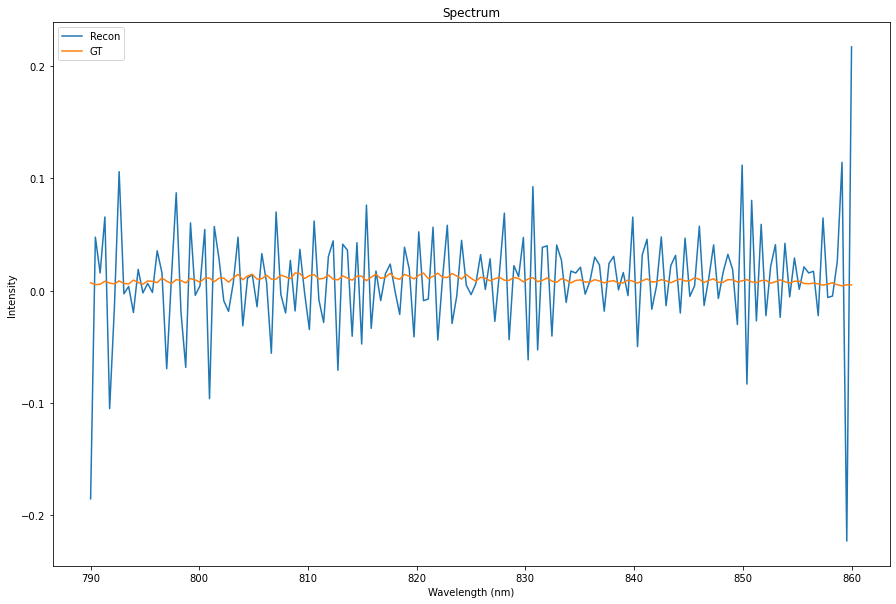

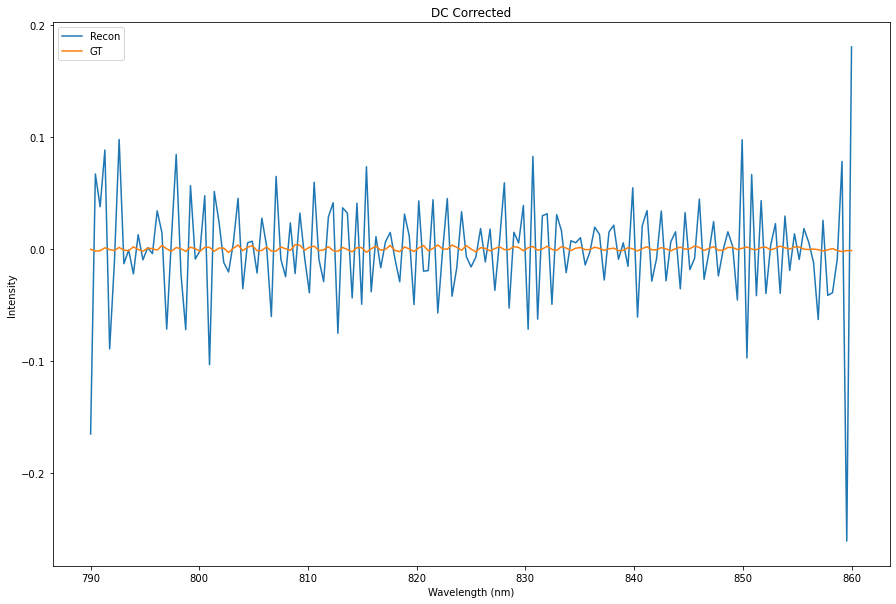

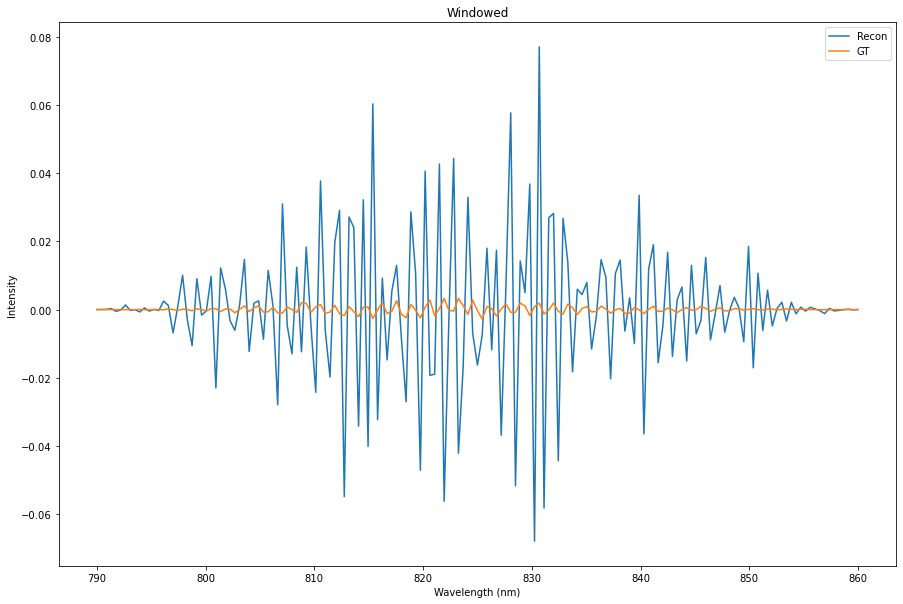

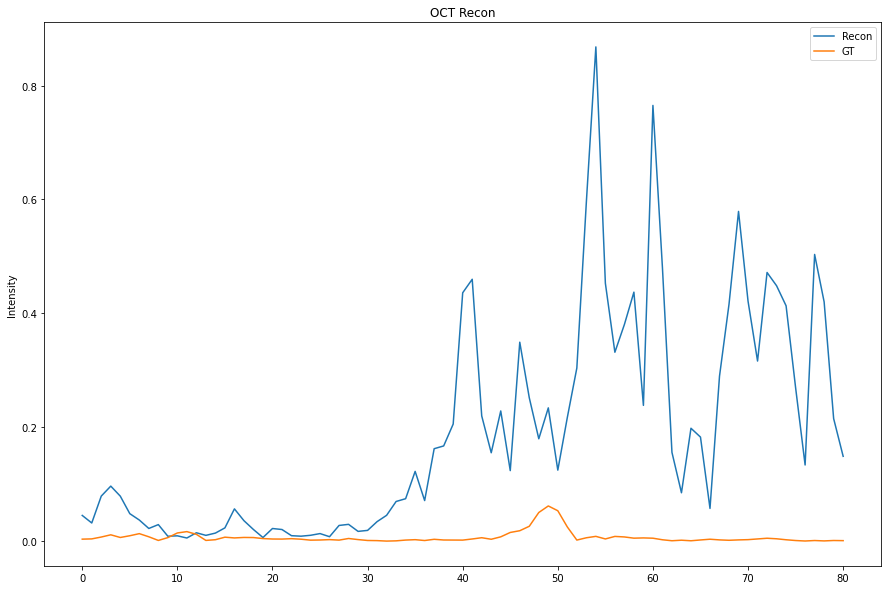

In [84]:
# Calculate and display DC signal
recon_dc = dc_estimate(waves, recon, 6)

# Display Interpolated Ground Truth
plt.figure(figsize = (15,10))
plt.plot(waves, recon)
plt.plot(waves, interp_gt)
plt.title('Spectrum')
plt.legend(['Recon','GT'])
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display DC Corrected Spectrum
recon_corrected = recon-recon_dc
plt.figure(figsize = (15,10))
plt.plot(waves, recon_corrected)
plt.plot(waves, interp_gt_corrected)
plt.legend(['Recon','GT'])
plt.title('DC Corrected')
plt.ylabel('Intensity')

plt.xlabel('Wavelength (nm)')
plt.show()

# Display windowed spectrum
window = torch.tensor(np.hanning(len(waves)))
recon_windowed = recon_corrected * window
plt.figure(figsize = (15,10))
plt.plot(waves, recon_windowed)
plt.plot(waves, interp_gt_windowed)
plt.title('Windowed')
plt.legend(['Recon','GT'])
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display FFT
recon_fft = torch.fft.fftn(recon_windowed)
plt.figure(figsize = (15,10))
plt.plot(torch.fft.fftshift(recon_fft).abs()[int(len(interp_gt)/2):])
plt.plot(torch.fft.fftshift(interp_gt_fft).abs()[int(len(interp_gt)/2):])
plt.legend(['Recon','GT'])
plt.title('OCT Recon')
plt.ylabel('Intensity')
plt.show()

In [24]:
recon = torch.zeros_like(waves, dtype = dtype)
step_size = 1e-8
iters = 200
lam = 1e-2
gams = torch.logspace(.0001,1,100)
pinv = torch.pinverse(A,lam)


total_loss = []
for jj in range(len(gams)):
    loss = []
    recon = torch.matmul(pinv,meas)
    for ii in range(iters):
#         residual = torch.matmul(A,recon)-meas
#         calc_g = 2*torch.matmul(A.T,residual)
#         z = recon - step_size*calc_g
        b = torch.matmul(pinv,meas) + lam * recon
        z = torch.matmul(pinv,torch.matmul(A,b))
        recon = inv_sparse_transform(complex_soft_thr(sparse_transform(z),gams[jj]))
        loss.append(torch.norm(recon-interp_gt))
    total_loss.append(loss)
plt.figure()
plt.plot(torch.matmul(A,recon))
plt.plot(meas)
plt.show()

plt.figure()
plt.plot(recon)
plt.plot(interp_gt)
plt.show()

plt.figure()
plt.plot(loss)
plt.show()


TypeError: sparse_transform() missing 1 required positional argument: 'dc'

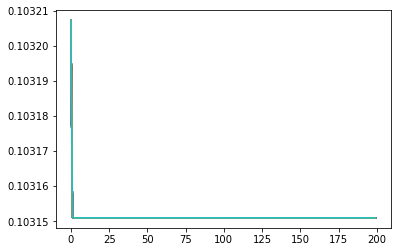

In [74]:
plt.figure()
lowest = []
for ii in range(100):
    lowest.append(np.min(total_loss[ii])) 
    plt.plot(total_loss[ii])
plt.show()

In [75]:
idx = np.argmin(lowest)
print(idx)
print(np.argmin(total_loss[idx]))

0
2


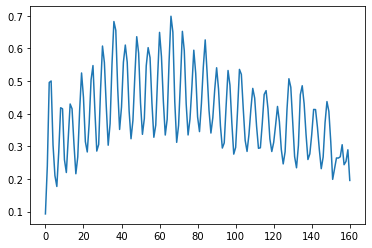

In [66]:
plt.figure()
plt.plot(inv_sparse_transform(complex_soft_thr(sparse_transform(interp_gt),.05)))
plt.show()

<ipython-input-204-a862923d57e0>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dc = moving_average(torch.tensor(gt_intensity), 10)


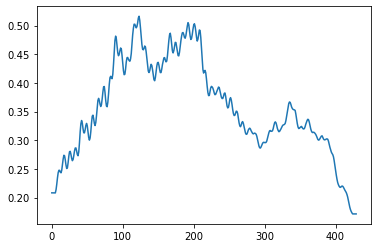

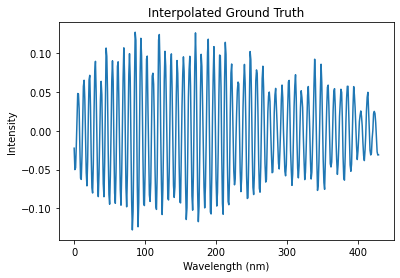

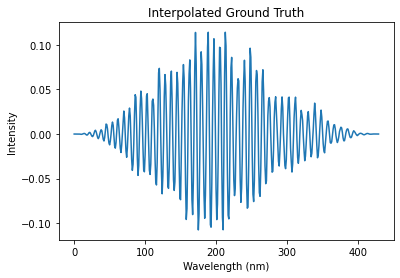

/home/emarkley/anaconda3/envs/Spectrometer/lib/python3.9/site-packages/torch/_tensor.py:645: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


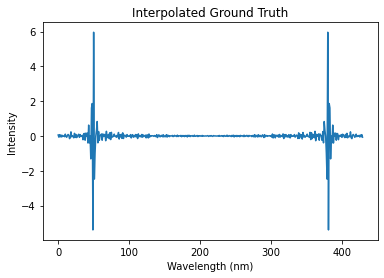

In [204]:
dc = moving_average(torch.tensor(gt_intensity), 10)
plt.figure()
plt.plot(dc)
plt.show()

plt.figure()
plt.plot(gt_intensity-dc)
plt.title('Interpolated Ground Truth')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

plt.figure()
plt.plot(window*(gt_intensity-dc))
plt.title('Interpolated Ground Truth')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

plt.figure()
plt.plot(torch.fft.fftn(window*(gt_intensity-dc)))
plt.title('Interpolated Ground Truth')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()



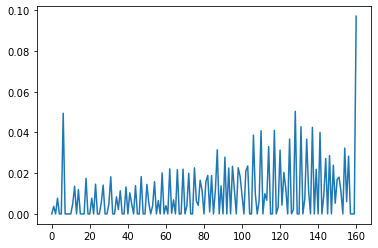

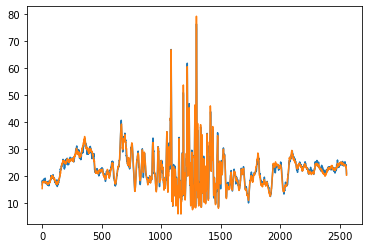

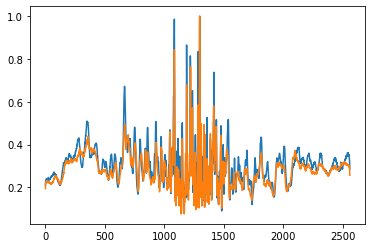

In [126]:
sim_meas = torch.matmul(A.T, interp_gt)
plt.figure()
plt.plot(sim_meas/torch.max(sim_meas))
plt.plot(meas/torch.max(meas))
plt.show()

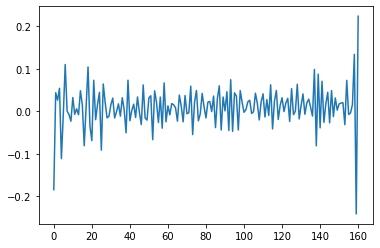

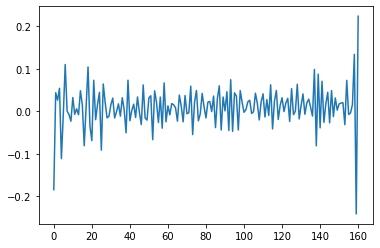

In [117]:
y = torch.matmul(torch.pinverse(A.T,rcond=5e-15),torch.unsqueeze(meas,-1))
plt.figure()
plt.plot(y)
plt.show()
plt.figure()
plt.plot(y)
plt.show()

In [ ]:
plt.figure()
plt.plot(gt_waves, gt_intensity)
plt.title('Interpolated Ground Truth')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

plt.figure()
plt.plot(waves, torch.fft.fftshift(torch.fft.fftn(interp_gt)))
plt.title('Interpolated Ground Truth')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()